In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import logging
from pathlib import Path
from typing import Optional

import arviz as az
import numpyro

from hb_mep.config import HBMepConfig
from hb_mep.data_access import DataClass
# from hb_mep.models.rats import RectifiedLogistic
from hb_mep.models.rats.utils import load_data
from hb_mep.utils import (plot, ceil)
from hb_mep.utils.constants import (
    INTENSITY,
    PARTICIPANT,
    FEATURES,
    RESPONSE
)

numpyro.set_platform("cpu")
numpyro.set_host_device_count(12)
numpyro.enable_x64()

PARENT_PATH = Path(os.getcwd()).parent.parent.parent.absolute()
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)


import logging

import numpy as np
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist

from hb_mep.config import HBMepConfig
from hb_mep.models.baseline import Baseline
from hb_mep.models.utils import Site as site

logger = logging.getLogger(__name__)



In [3]:
import os
import logging
from pathlib import Path
from typing import Optional

import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import jax
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

from hb_mep.config import HBMepConfig
from hb_mep.models.utils import Site as site
from hb_mep.utils import (
    timing,
    make_combinations,
    evaluate_posterior_mean,
    evaluate_hpdi_interval
)

logger = logging.getLogger(__name__)


def _estimate_threshold(
    self,
    combination: tuple[int],
    posterior_samples: dict,
    prob: float = .95
):
    """ Prepare index """
    ind = [slice(None)] + list(combination) + [slice(None)]
    ind = ind[::-1]

    """ Posterior mean """
    posterior_samples = posterior_samples[site.a][tuple(ind)]
    threshold = evaluate_posterior_mean(
        posterior_samples=posterior_samples,
        prob=prob
    )

    """ HPDI Interval """
    hpdi_interval = evaluate_hpdi_interval(
        posterior_samples=posterior_samples,
        prob=prob
    )
    return threshold, posterior_samples, hpdi_interval

def _predict(
    self,
    intensity: np.ndarray,
    combination: tuple,
    posterior_samples: Optional[dict] = None,
    num_samples: int = 100
):
    if posterior_samples is None:   # Prior predictive
        predictive = Predictive(
            model=self._model, num_samples=num_samples
        )
    else:   # Posterior predictive
        predictive = Predictive(
            model=self._model, posterior_samples=posterior_samples
        )

    """ Prepare dataset """
    combination = np.array(list(combination))
    combination = np.tile(combination, (intensity.shape[0], 1)).T
    participant = combination[0]
    features = combination[1:]

    """ Predictions """
    predictions = predictive(
        self.rng_key,
        intensity=intensity,
        participant=participant,
        features=features
    )
    return predictions

@timing
def plot(
    self,
    df: pd.DataFrame,
    save_path: Path,
    posterior_samples: dict,
    encoder_dict: Optional[dict] = None,
    mat: Optional[np.ndarray] = None,
    time: Optional[np.ndarray] = None,
    auc_window: Optional[list[float]] = None
):
    if mat is not None:
        assert time is not None
        assert auc_window is not None

    combinations = make_combinations(df=df, columns=self.columns)
    n_combinations = len(combinations)

    intensity = self.x_space

    n_fig_columns = 3 * self.n_response
    if mat is not None: n_fig_columns += self.n_response

    """ Setup PDF """
    pdf = PdfPages(save_path)

    n_fig_rows = 10
    n_pdf_pages = n_combinations // n_fig_rows

    if n_combinations % n_fig_rows:
        n_pdf_pages += 1

    combination_counter = 0

    for page in range(n_pdf_pages):
        n_rows_current_page = min(
            n_fig_rows,
            n_combinations - page * n_fig_rows
        )

        fig, axes = plt.subplots(
            n_rows_current_page,
            n_fig_columns,
            figsize=(n_fig_columns * 5, n_rows_current_page * 3),
            constrained_layout=True,
            squeeze=False
        )

        for i in range(n_rows_current_page):
            combination = combinations[combination_counter]

            ind = df[self.columns].apply(tuple, axis=1).isin([combination])
            temp_df = df[ind].reset_index(drop=True).copy()

            predictions = _predict(
                self=self,
                intensity=intensity,
                combination=combination,
                posterior_samples=posterior_samples
            )
            mean = predictions[site.mean]
            mean_posterior_mean = evaluate_posterior_mean(mean)

            threshold, threshold_posterior, hpdi_interval = \
                _estimate_threshold(self, combination, posterior_samples)

            j = 0
            for (r, response) in enumerate(self.response):
                """ Plots """
                sns.scatterplot(
                    data=temp_df,
                    x=self.intensity,
                    y=response,
                    ax=axes[i, j]
                )
                sns.scatterplot(
                    data=temp_df,
                    x=self.intensity,
                    y=response,
                    alpha=.4,
                    ax=axes[i, j + 1]
                )

                sns.kdeplot(
                    x=threshold_posterior[:, r],
                    color="b",
                    ax=axes[i, j + 1],
                    alpha=.4
                )
                sns.lineplot(
                    x=intensity,
                    y=mean_posterior_mean[:, r],
                    label="Mean Posterior",
                    color="r",
                    alpha=0.4,
                    ax=axes[i, j + 1]
                )

                sns.kdeplot(
                    x=threshold_posterior[:, r],
                    color="b",
                    ax=axes[i, j + 2]
                )
                axes[i, j + 2].axvline(
                    threshold[r],
                    linestyle="--",
                    color="r",
                    label=f"Mean Posterior"
                )
                axes[i, j + 2].axvline(
                    hpdi_interval[:, r][0],
                    linestyle="--",
                    color="g",
                    label="95% HPDI"
                )
                axes[i, j + 2].axvline(
                    hpdi_interval[:, r][1],
                    linestyle="--",
                    color="g"
                )

                """ Labels """
                title = f"{response} - {tuple(self.columns)} - {combination}"
                axes[i, j].set_title(title)

                if encoder_dict is not None:
                    combination_inverse = []
                    for column, value in zip(self.columns, combination):
                        combination_inverse.append(
                            encoder_dict[column] \
                                .inverse_transform(np.array([value]))[0]
                        )
                    title = f"{response} - {tuple(combination_inverse)}"
                else:
                    title = f"{response} - Model Fit"

                axes[i, j + 1].set_title(title)

                skew = stats.skew(a=threshold_posterior[:, r])
                kurt = stats.kurtosis(a=threshold_posterior[:, r])

                title = f"{response} - TH: {threshold[r]:.2f}"
                title += f", CI: ({hpdi_interval[:, r][0]:.1f}, {hpdi_interval[:, r][1]:.1f})"
                title += f", LEN: {hpdi_interval[:, r][1] - hpdi_interval[:, r][0]:.1f}"
                title += r', $\overline{\mu_3}$'
                title += f": {skew:.1f}"
                title += f", K: {kurt:.1f}"
                axes[i, j + 2].set_title(title)

                base = 20
                ticks = np.arange(0, ceil(df[self.intensity].max(), base=base), base)
                for idx in [j, j + 1]:
                    axes[i, idx].set_xticks(ticks=ticks)
                    axes[i, idx].tick_params(axis="x", rotation=90)

                """ Limits """
                axes[i, j + 1].set_xlim(
                    left=max(0, temp_df[self.intensity].min() - 2 * self.x_pad),
                    right=temp_df[self.intensity].max() + self.x_pad
                )
                axes[i, j + 1].set_ylim(
                    bottom=0, top=temp_df[response].max() + .1
                )

                """ Legends """
                axes[i, j + 1].legend(loc="upper left")
                axes[i, j + 2].legend(loc="upper right")

                j += 3

                """ EEG Data """
                if mat is not None:
                    ax = axes[i, j]
                    temp_mat = mat[ind, :, r]

                    for k in range(temp_mat.shape[0]):
                        x = temp_mat[k, :]/60 + temp_df[self.intensity].values[k]
                        ax.plot(x, time, color="green", alpha=.4)

                    ax.axhline(
                        y=auc_window[0],
                        color="red",
                        linestyle='--',
                        alpha=.4,
                        label=f"AUC Window {auc_window}"
                    )
                    ax.axhline(
                        y=auc_window[1],
                        color="red",
                        linestyle='--',
                        alpha=.4
                    )

                    ax.set_ylim(bottom=-0.001, top=auc_window[1] + .005)

                    ax.set_xlabel(f"{self.intensity}")
                    ax.set_ylabel(f"Time")

                    ax.legend(loc="upper right")
                    ax.set_title(f"Motor Evoked Potential")

                    ax.set_xticks(ticks=ticks)
                    ax.tick_params(axis="x", rotation=90)

                    j += 1

            combination_counter += 1

        pdf.savefig(fig)
        plt.close()

    pdf.close()
    plt.show()

@timing
def predictive_check(
    self,
    df: pd.DataFrame,
    posterior_samples: Optional[dict] = None
):
    is_posterior_check = True
    if posterior_samples is None: is_posterior_check = False

    if is_posterior_check:
        check_type = "Posterior"
    else:
        check_type = "Prior"

    combinations = make_combinations(df=df, columns=self.columns)
    n_combinations = len(combinations)

    intensity = self.x_space
    predictions = None

    n_fig_columns = 3 * self.n_response

    fig, axes = plt.subplots(
        n_combinations,
        n_fig_columns,
        figsize=(n_fig_columns * 6, n_combinations * 3),
        constrained_layout=True,
        squeeze=False
    )

    for i, combination in enumerate(combinations):
        ind = df[self.columns] \
                .apply(tuple, axis=1) \
                .isin([combination])

        temp_df = df[ind].reset_index(drop=True).copy()

        if is_posterior_check or predictions is None:
            predictions = _predict(
                self=self,
                intensity=intensity,
                combination=combination,
                posterior_samples=posterior_samples
            )
            obs = predictions[site.obs]
            mean = predictions[site.mean]

            obs_posterior_mean = evaluate_posterior_mean(obs)
            mean_posterior_mean = evaluate_posterior_mean(mean)

            hpdi_obs = evaluate_hpdi_interval(obs, prob=.95)
            hpdi_mean = evaluate_hpdi_interval(mean, prob=.95)

            """ Additional """
            hpdi_obs_90 = evaluate_hpdi_interval(obs, prob=.90)
            hpdi_obs_80 = evaluate_hpdi_interval(obs, prob=.80)
            hpdi_obs_65 = evaluate_hpdi_interval(obs, prob=.65)

        j = 0
        for (r, response) in enumerate(self.response):
            """ Plots """
            sns.scatterplot(
                data=temp_df,
                x=self.intensity,
                y=response,
                alpha=.4,
                ax=axes[i, j]
            )
            sns.lineplot(
                x=intensity,
                y=mean_posterior_mean[:, r],
                label=f"Mean {check_type}",
                color="r",
                alpha=0.4,
                ax=axes[i, j]
            )

            axes[i, j + 1].plot(
                intensity,
                obs_posterior_mean[:, r],
                color="k",
                label="Mean Prediction"
            )
            axes[i, j + 1].fill_between(
                intensity,
                hpdi_obs[0, :, r],
                hpdi_obs[1, :, r],
                color="paleturquoise",
                label="95% HPDI"
            )

            """ Additional """
            axes[i, j + 1].fill_between(
                intensity,
                hpdi_obs_90[0, :, r],
                hpdi_obs_90[1, :, r],
                color="C1",
                label="90% HPDI"
            )
            axes[i, j + 1].fill_between(
                intensity,
                hpdi_obs_80[0, :, r],
                hpdi_obs_80[1, :, r],
                color="C2",
                label="80% HPDI"
            )
            axes[i, j + 1].fill_between(
                intensity,
                hpdi_obs_65[0, :, r],
                hpdi_obs_65[1, :, r],
                color="C3",
                label="65% HPDI"
            )

            sns.scatterplot(
                data=temp_df,
                x=self.intensity,
                y=response,
                color="y",
                edgecolor="k",
                ax=axes[i, j + 1]
            )

            axes[i, j + 2].plot(
                intensity,
                mean_posterior_mean[:, r],
                color="k",
                label=f"Mean {check_type}"
            )
            axes[i, j + 2].fill_between(
                intensity,
                hpdi_mean[0, :, r],
                hpdi_mean[1, :, r],
                color="paleturquoise",
                label="95% HPDI"
            )
            sns.scatterplot(
                data=temp_df,
                x=self.intensity,
                y=response,
                color="y",
                edgecolor="k",
                ax=axes[i, j + 2]
            )

            """ Labels """
            title = f"{response} - {tuple(self.columns)} - {combination}"
            axes[i, j].set_title(title)
            axes[i, j + 1].set_title(f"{check_type} Predictive")
            axes[i, j + 2].set_title(f"{check_type} Predictive Mean")

            base = 20
            ticks = np.arange(0, ceil(df[self.intensity].max(), base=base), base)
            for idx in [j, j + 1, j + 2]:
                axes[i, idx].set_xticks(ticks=ticks)
                axes[i, idx].tick_params(axis="x", rotation=90)

            """ Limits """
            axes[i, j].set_xlim(
                left=max(0, temp_df[self.intensity].min() - 5 * self.x_pad),
                right=temp_df[self.intensity].max() + 5 * self.x_pad
            )
            axes[i, j].set_xlim(
                left=max(0, temp_df[self.intensity].min() - 5 * self.x_pad),
                right=temp_df[self.intensity].max() + 5 * self.x_pad
            )
            axes[i, j + 1].set_xlim(
                left=max(0, temp_df[self.intensity].min() - 5 * self.x_pad),
                right=temp_df[self.intensity].max() + 5 * self.x_pad
            )
            axes[i, j + 2].set_xlim(
                left=max(0, temp_df[self.intensity].min() - 5 * self.x_pad),
                right=temp_df[self.intensity].max() + 5 * self.x_pad
            )

            """ Legends """
            axes[i, j].legend(loc="upper left")
            axes[i, j + 1].legend(loc="upper left")
            axes[i, j + 2].legend(loc="upper left")

            j += 3

    return fig

#### Load config

In [4]:
config = HBMepConfig()
config.CURRENT_PATH = PARENT_PATH

#### Load data and preprocess

In [5]:
data = DataClass(config)

""" Load """
fpath = "/mount/hdd1/acute_mapping/proc"
dir_name = "physio"

dir = os.path.join(fpath, dir_name)

participants = range(1, 9)
subdir_pattern = ["*J_RCML_000*"]

df, mat, time, auc_window = load_data(
    dir=dir, participants=participants, subdir_pattern=subdir_pattern
)

""" Custom filter """
columns = [PARTICIPANT] + FEATURES
# ind = (df.participant == "amap06") & (df.compound_position == "-C8L")
ind = (df.participant == "amap06")

df = df[ind].copy()
df.reset_index(drop=True, inplace=True)

mat = mat[ind, ...]

""" Preprocess """
df, encoder_dict, mat = data.build(df=df, mat=mat)

2023-07-03 14:18:11,930 - hb_mep.utils.utils - INFO - func:load_data took: 24.20 sec
2023-07-03 14:18:11,933 - hb_mep.data_access.core - INFO - Processing data ...
2023-07-03 14:18:11,939 - hb_mep.utils.utils - INFO - func:preprocess took: 0.01 sec
2023-07-03 14:18:11,939 - hb_mep.utils.utils - INFO - func:build took: 0.01 sec


In [6]:
class RectifiedLogistic(Baseline):
    def __init__(self, config: HBMepConfig):
        super(RectifiedLogistic, self).__init__(config=config)
        self.name = "Rectified_Logistic"

        self.x_space = np.linspace(0, 800, 2000)

    def _model(self, intensity, participant, features, response_obs=None):
        if response_obs is not None:
            self.n_response = response_obs.shape[1]

        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)

        n_data = intensity.shape[0]
        n_participant = np.unique(participant).shape[0]
        n_feature0 = np.unique(feature0).shape[0]

        with numpyro.plate("n_response", self.n_response, dim=-1):
            with numpyro.plate("n_participant", n_participant, dim=-2):
                """ Hyper-priors """
                a_mean = numpyro.sample(
                    site.a_mean,
                    dist.TruncatedNormal(150, 20, low=0)
                )
                a_scale = numpyro.sample(site.a_scale, dist.HalfNormal(20))

                b_scale = numpyro.sample(site.b_scale, dist.HalfNormal(0.5))

                h_scale = numpyro.sample("h_scale", dist.HalfNormal(5))
                v_scale = numpyro.sample("v_scale", dist.HalfNormal(50))

                lo_scale = numpyro.sample(site.lo_scale, dist.HalfNormal(0.05))

                with numpyro.plate("n_feature0", n_feature0, dim=-3):
                    """ Priors """
                    a = numpyro.sample(
                        site.a,
                        dist.TruncatedNormal(a_mean, a_scale, low=0)
                    )
                    b = numpyro.sample(site.b, dist.HalfCauchy(b_scale))

                    h = numpyro.sample("h", dist.HalfCauchy(h_scale))
                    v = numpyro.sample("v", dist.HalfCauchy(v_scale))

                    lo = numpyro.sample(site.lo, dist.HalfCauchy(lo_scale))

                    gamma_scale_offset = numpyro.sample(
                        site.gamma_scale_offset, dist.HalfCauchy(10)
                    )
                    gamma_scale_slope = numpyro.sample(
                        site.gamma_scale_slope, dist.HalfCauchy(10)
                    )

        """ Model """
        mean = numpyro.deterministic(
            site.mean,
            lo[feature0, participant] + \
            jnp.maximum(
                0,
                -1 + \
                (h[feature0, participant] + 1) / \
                jnp.power(
                    1 + \
                    (jnp.power(1 + h[feature0, participant], v[feature0, participant]) - 1) * \
                    jnp.exp(-b[feature0, participant] * (intensity - a[feature0, participant])),
                    1 / v[feature0, participant]
                )
            )
        )
        scale = numpyro.deterministic(
            "scale",
            gamma_scale_offset[feature0, participant] + \
            gamma_scale_slope[feature0, participant] * (1 / mean)
        )

        """ Observation """
        with numpyro.plate(site.data, n_data):
            return numpyro.sample(
                site.obs,
                dist.Gamma(mean * scale, scale).to_event(1),
                obs=response_obs
            )


model = RectifiedLogistic(config)
mcmc, posterior_samples = model.run_inference(df)
mcmc.print_summary(prob=.95)

# model = RectifiedLogistic(config)
# predictive_check(model, df);

2023-07-03 14:18:12,001 - jax._src.xla_bridge - INFO - Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-07-03 14:18:12,002 - jax._src.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-07-03 14:18:12,002 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
2023-07-03 14:18:12,002 - jax._src.xla_bridge - INFO - Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
2023-07-03 14:18:12,013 - hb_mep.models.baseline - INFO - Running inference with Rectified_Logistic ...


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-07-03 14:23:29,500 - hb_mep.utils.utils - INFO - func:run_inference took: 5 min and 17.49 sec



                                mean       std    median      2.5%     97.5%     n_eff     r_hat
                  a[0,0,0]    293.98      4.88    293.08    285.09    303.46    501.53      1.02
                  a[1,0,0]    248.01     16.80    249.26    213.91    278.41   2397.88      1.00
                  a[2,0,0]    215.50     12.25    214.28    193.08    239.85   1094.48      1.01
                  a[3,0,0]    257.07     12.45    257.67    232.28    281.26   2554.09      1.00
                  a[4,0,0]    132.18      1.78    132.28    128.48    135.49   2383.83      1.00
                  a[5,0,0]    219.99     10.02    220.11    198.67    238.56   1862.55      1.00
                  a[6,0,0]    164.68      0.99    164.77    162.65    166.51   2787.07      1.00
                  a[7,0,0]    105.96     22.34    103.73     64.20    153.65    826.25      1.01
                  a[8,0,0]    268.83      7.39    268.70    254.07    283.83   2263.70      1.00
                  a[9,0,0]   

In [7]:
save_path = os.path.join(data.reports_path, "paper_fit_3.pdf")

pred = plot(
    self=model, df=df, posterior_samples=posterior_samples, encoder_dict=encoder_dict, save_path=save_path
);

2023-07-03 14:29:39,901 - hb_mep.utils.utils - INFO - func:plot took: 6 min and 10.07 sec


2023-07-03 14:39:11,553 - hb_mep.utils.utils - INFO - func:predictive_check took: 9 min and 31.51 sec


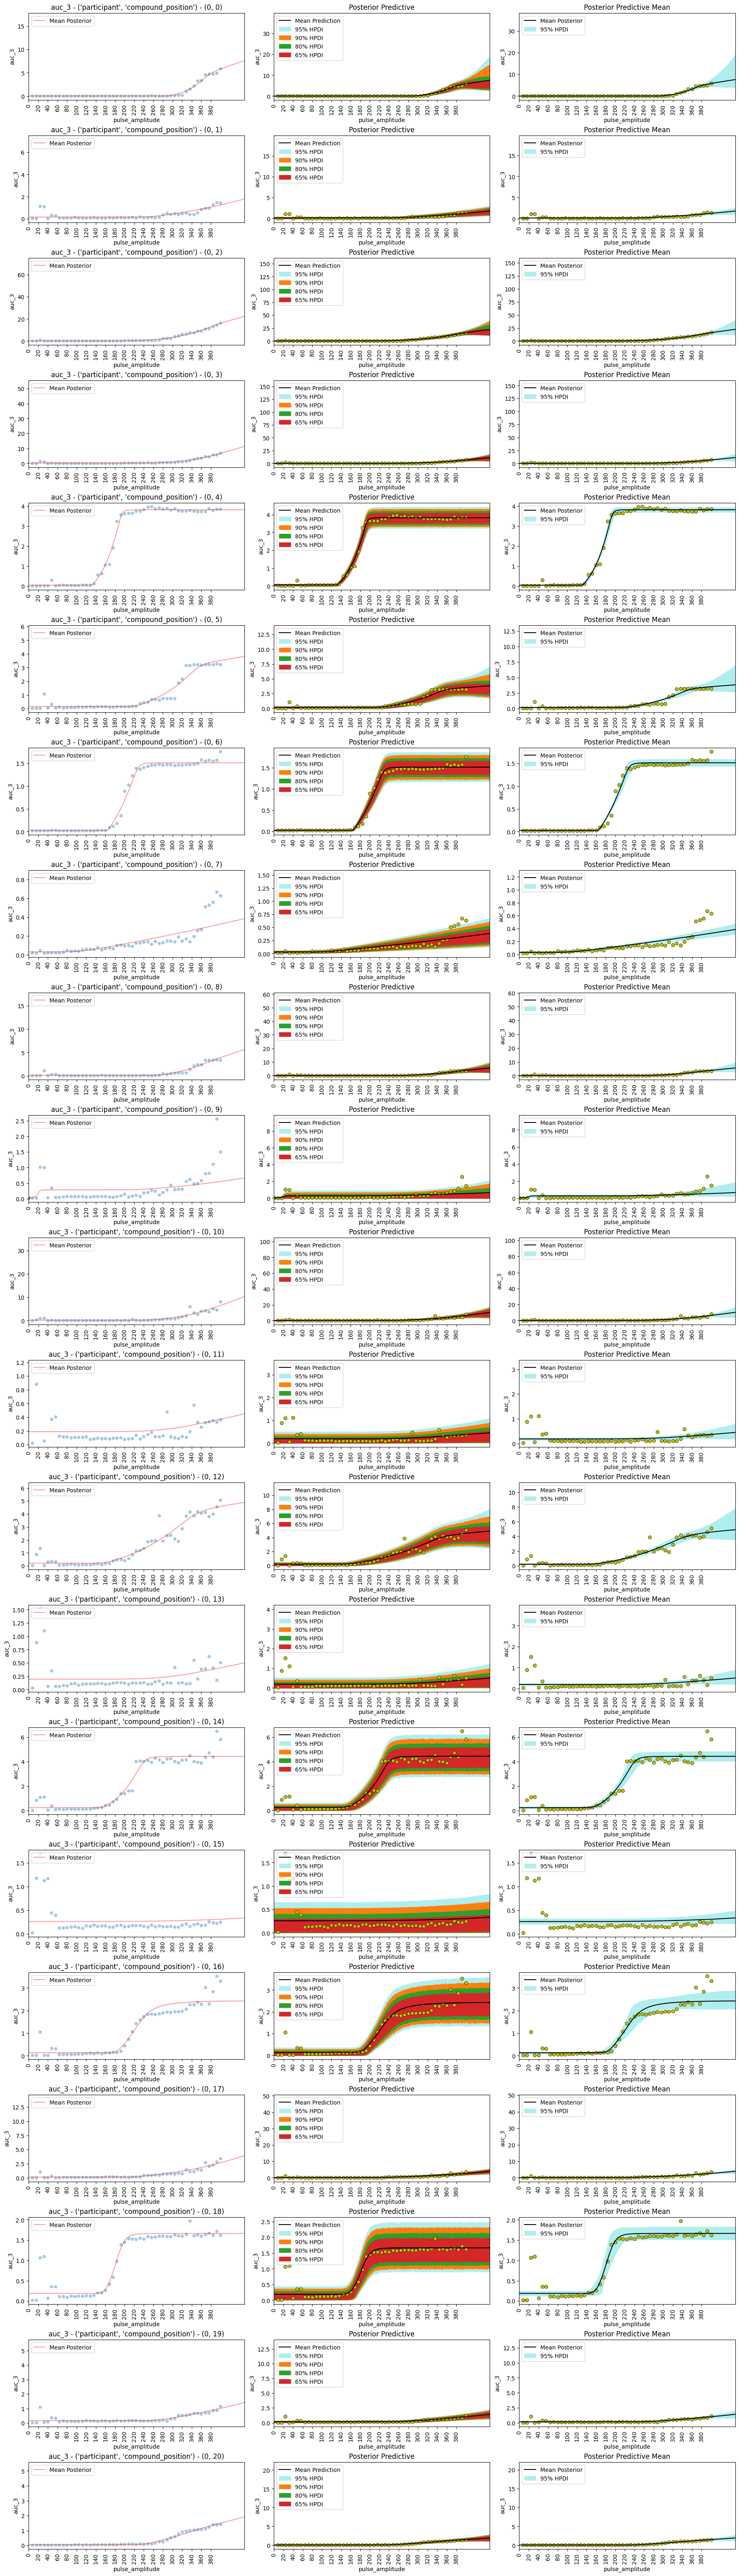

In [8]:
predictive_check(model, df, posterior_samples);

In [9]:
combination = (0, 0)

predictions = _predict(
    self=model,
    intensity=model.x_space,
    combination=combination,
    posterior_samples=posterior_samples
)

obs = predictions["obs"]
mean = predictions["mean"]

obs_mean_posterior = evaluate_posterior_mean(obs)
mean_mean_posterior = evaluate_posterior_mean(mean)

<Axes: xlabel='pulse_amplitude', ylabel='auc_3'>

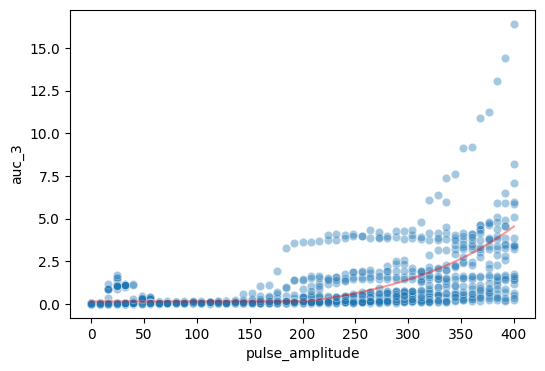

In [10]:
a = np.array(posterior_samples["a"].mean()).tolist()
b = np.array(posterior_samples["b"].mean()).tolist()
lo = np.array(posterior_samples["lo"].mean()).tolist()
h = np.array(posterior_samples["h"].mean()).tolist()
v = np.array(posterior_samples["v"].mean()).tolist()

x_space = np.arange(0, ceil(df[INTENSITY].max(), 20), .1)

y_space = \
    lo + \
    jnp.maximum(
        0,
        -1 + \
        (h + 1) / \
        jnp.power(
            1 + \
            (jnp.power(1 + h, v) - 1) * \
            jnp.exp(-b * (x_space - a)),
            1 / v
        )
    )

plt.figure(figsize=(6, 4))

sns.lineplot(x=x_space, y=y_space, color="red", alpha=.4)
sns.scatterplot(data=df, x=INTENSITY, y=RESPONSE[0], alpha=.4)


In [11]:
x_space.shape

(4000,)

In [12]:
y_space

Array([0.14166809, 0.14166809, 0.14166809, ..., 4.52689199, 4.53153951,
       4.53619104], dtype=float64)

2023-07-03 14:49:06,859 - hb_mep.utils.utils - INFO - func:predictive_check took: 9 min and 29.87 sec


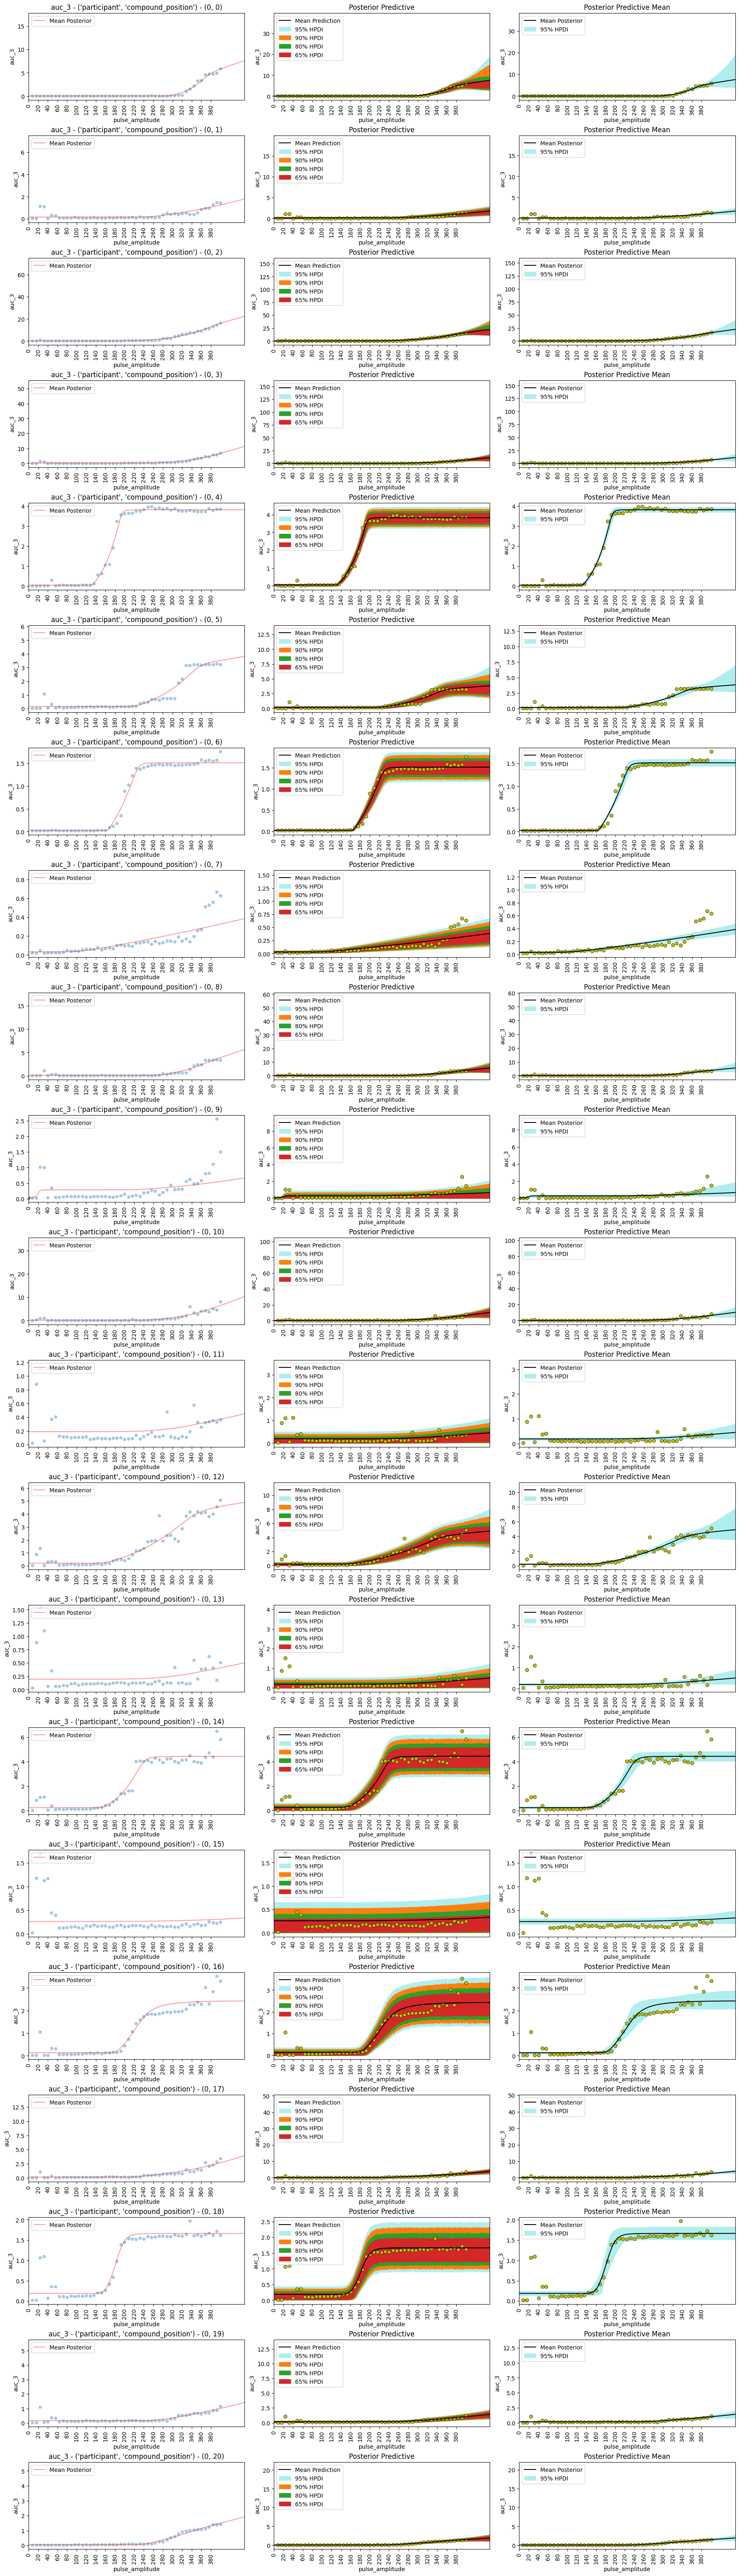

In [13]:
predictive_check(model, df, posterior_samples);